In [2]:
#data manipulation
import numpy as np
import pandas as pd

#visualization
import matplotlib.pyplot as plt
import seaborn as sns

#machine learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, make_scorer

#train test pipeline
import train_test_pipeline

#settings
from IPython.display import display

plt.style.use('bmh')
%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['axes.titlepad'] = 25
sns.set_color_codes('pastel')

In [3]:
orders = pd.read_csv('orders.csv', header = 0)
departments = pd.read_csv('departments.csv', header = 0)
products = pd.read_csv('products.csv', header = 0)
order_products_train = pd.read_csv('order_products__train.csv', header = 0)
order_products_prior = pd.read_csv('order_products__prior.csv', header = 0)
aisles = pd.read_csv('aisles.csv', header = 0)

In [4]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


C:\Users\rossr\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


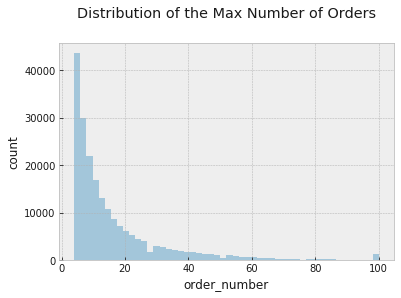

In [5]:
plt.title('Distribution of the Max Number of Orders')
plt.ylabel('count')
sns.distplot(orders.groupby('user_id').order_number.max(), kde = False, norm_hist = False)

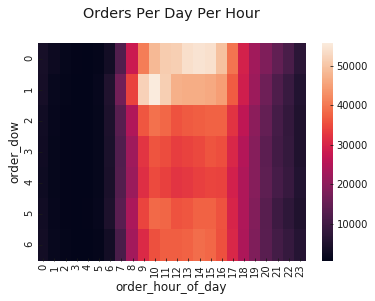

In [6]:
to_plot = pd.pivot_table(data = orders,
                         index = 'order_dow',
                         columns = 'order_hour_of_day',
                         values = 'order_id',
                         aggfunc = 'count')

plt.title('Orders Per Day Per Hour')
sns.heatmap(to_plot)

<BarContainer object of 32 artists>

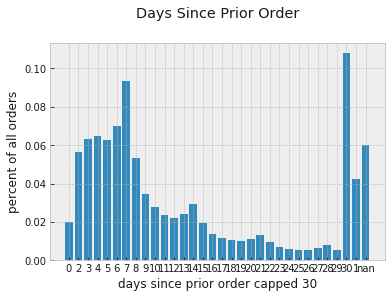

In [7]:
to_plot = orders.days_since_prior_order.value_counts(normalize = True, dropna = False, sort = False)
x_ticks = range(len(to_plot))
plt.xticks(x_ticks, [i if np.isnan(i) else int(i) for i in to_plot.index])
plt.title('Days Since Prior Order')
plt.xlabel('days since prior order capped 30')
plt.ylabel('percent of all orders')
plt.bar(x_ticks, to_plot)

<BarContainer object of 75 artists>

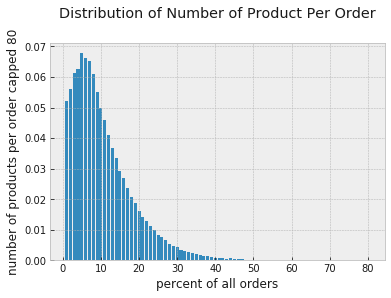

In [8]:
to_plot = order_products_train.groupby('order_id')\
.add_to_cart_order.max()\
.value_counts(normalize = True, dropna = False, sort = False)
plt.title('Distribution of Number of Product Per Order')
plt.xlabel('percent of all orders')
plt.ylabel('number of products per order capped 80')
plt.bar(to_plot.index, to_plot)

In [9]:
order_products_train_pivot = pd.pivot_table(data = order_products_train[order_products_train.add_to_cart_order <= 5],
                                            index = 'order_id',
                                            columns = 'add_to_cart_order',
                                            values = 'product_id',
                                            fill_value = 0)

In [10]:
order_products_train_pivot.head()

add_to_cart_order,1,2,3,4,5
order_id,,,,,
1,49302,11109,10246,49683,43633
36,39612,19660,49235,43086,46620
38,11913,18159,4461,21616,23622
96,20574,30391,40706,25610,27966
98,8859,19731,43654,13176,4357


In [11]:
order_products_prior_pivot = pd.pivot_table(data = order_products_prior[order_products_prior.add_to_cart_order <= 5],
                                            index = 'order_id',
                                            columns = 'add_to_cart_order',
                                            values = 'product_id',
                                            fill_value = 0)

In [12]:
order_products_prior_pivot.head()

add_to_cart_order,1,2,3,4,5
order_id,,,,,
2,33120,28985,9327,45918,30035
3,33754,24838,17704,21903,17668
4,46842,26434,39758,27761,10054
5,13176,15005,47329,27966,23909
6,40462,15873,41897,0,0


In [13]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [14]:
products_by_department = order_products_train.\
merge(right = products,
      how = 'left',
      left_on = 'product_id',
      right_on = 'product_id').\
merge(right = departments,
      how = 'left',
      left_on = 'department_id',
      right_on = 'department_id').\
merge(right = aisles,
      how = 'left',
      left_on = 'aisle_id',
      right_on = 'aisle_id').\
drop(['order_id',
      'add_to_cart_order',
      'reordered',
      'aisle_id',
      'department_id',
      'aisle_id'],
     axis = 1)

In [15]:
products_by_department.head()

,product_id,product_name,department,aisle
0,49302,Bulgarian Yogurt,dairy eggs,yogurt
1,11109,Organic 4% Milk Fat Whole Milk Cottage Cheese,dairy eggs,other creams cheeses
2,10246,Organic Celery Hearts,produce,fresh vegetables
3,49683,Cucumber Kirby,produce,fresh vegetables
4,43633,Lightly Smoked Sardines in Olive Oil,canned goods,canned meat seafood


<BarContainer object of 21 artists>

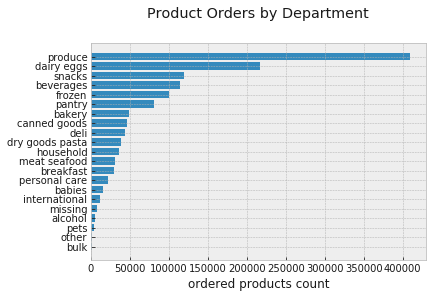

In [16]:
to_plot = products_by_department.department.value_counts(ascending = True)
plt.title('Product Orders by Department')
plt.xlabel('ordered products count')
plt.barh(to_plot.index, to_plot)

<BarContainer object of 20 artists>

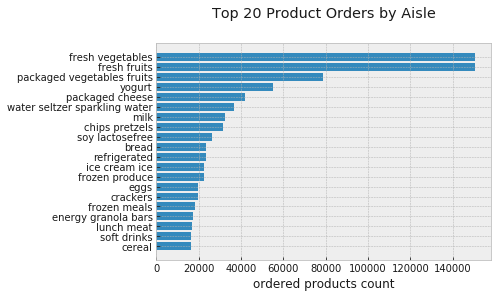

In [17]:
top_n = 20
to_plot = products_by_department.aisle.value_counts(ascending = True)
plt.title('Top %s Product Orders by Aisle' % top_n)
plt.xlabel('ordered products count')
plt.barh(to_plot.index[-top_n:], to_plot[-top_n:])

<BarContainer object of 40 artists>

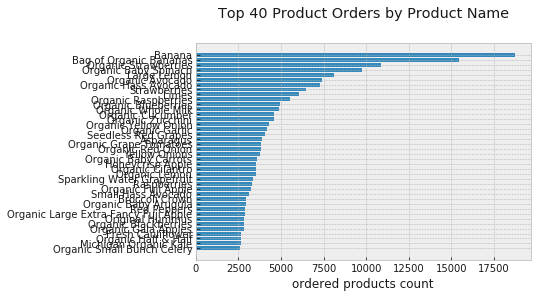

In [18]:
top_n = 40
to_plot = products_by_department.product_name.value_counts(ascending = True)
plt.title('Top %s Product Orders by Product Name' % top_n)
plt.xlabel('ordered products count')
plt.barh(to_plot.index[-top_n:], to_plot[-top_n:])

C:\Users\rossr\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


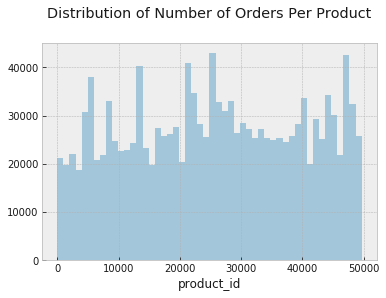

In [19]:
plt.title('Distribution of Number of Orders Per Product')
sns.distplot(products_by_department.product_id, kde = False, norm_hist = False)

In [20]:
#there are no common orders between order_products_train and order_products_prior
set(order_products_train.order_id.unique()) & set(order_products_prior.order_id.unique())

set()

In [21]:
orders_products = orders.\
merge(right = order_products_train_pivot.\
      append(order_products_prior_pivot),
      how = 'left',
      left_on = 'order_id',
      right_on = 'order_id')

In [22]:
orders_products.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,1,2,3,4,5
0,2539329,1,prior,1,2,8,NaN,196.0,14084.0,12427.0,26088.0,26405.0
1,2398795,1,prior,2,3,7,15.0,196.0,10258.0,12427.0,13176.0,26088.0
2,473747,1,prior,3,3,12,21.0,196.0,12427.0,10258.0,25133.0,30450.0
3,2254736,1,prior,4,4,7,29.0,196.0,12427.0,10258.0,25133.0,26405.0
4,431534,1,prior,5,4,15,28.0,196.0,12427.0,10258.0,25133.0,10326.0


In [23]:
orders_products.info(verbose = True, memory_usage = True, null_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3421083 entries, 0 to 3421082
Data columns (total 12 columns):
order_id                  3421083 non-null int64
user_id                   3421083 non-null int64
eval_set                  3421083 non-null object
order_number              3421083 non-null int64
order_dow                 3421083 non-null int64
order_hour_of_day         3421083 non-null int64
days_since_prior_order    3214874 non-null float64
1                         3346083 non-null float64
2                         3346083 non-null float64
3                         3346083 non-null float64
4                         3346083 non-null float64
5                         3346083 non-null float64
dtypes: float64(6), int64(5), object(1)
memory usage: 339.3+ MB


In [24]:
#append orders_train to orders_prior to get better statistics on the products usage
#drop eval_set and order_id
#convert the product columns (1, 2, 3...) to categories
#make pipeline over several models

In [25]:
#0 is a meaningful value for days_since_prior_order
#we can try using -1 for no prior orders
orders_products.days_since_prior_order.unique()

array([nan, 15., 21., 29., 28., 19., 20., 14.,  0., 30., 10.,  3.,  8.,
       13., 27.,  6.,  9., 12.,  7., 17., 11., 22.,  4.,  5.,  2., 23.,
       26., 25., 16.,  1., 18., 24.])

In [26]:
orders_products['days_since_prior_order'] = orders_products['days_since_prior_order'].fillna(-1)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(orders_products[['user_id',
                                                                     'order_dow',
                                                                     'order_hour_of_day',
                                                                     'days_since_prior_order']],
                                                    orders_products[1].fillna(0),
                                                    test_size = 0.3, random_state = 42)

In [28]:
models = {'bayes': GaussianNB(),
          'adaboost': AdaBoostClassifier()}

In [29]:
model_explorer = train_test_pipeline.MultiEstimator(models, make_scorer(f1_score, average = 'weighted'))

In [30]:
train_limit = int(10e3)
model_explorer.fit(X_train[:train_limit], y_train[:train_limit]).get_score_dataframe()

C:\Users\rossr\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\rossr\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\rossr\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\rossr\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predic

C:\Users\rossr\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\rossr\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\rossr\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\rossr\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\rossr\Anaconda3\lib\site-packages\sklearn\metrics\classification

C:\Users\rossr\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\rossr\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\rossr\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\rossr\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\rossr\Anaconda3\lib\site-packages\sklearn\metrics\c

C:\Users\rossr\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


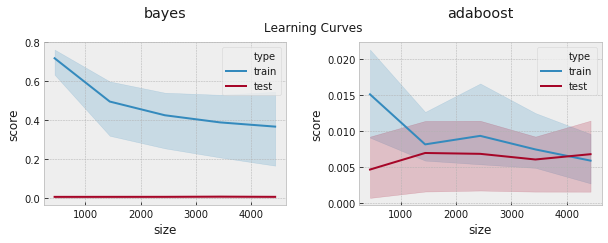

In [31]:
model_explorer.draw_learning_curves()